# Cybersecurity Intrusion Detection

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score,accuracy_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('cybersecurity_intrusion_data.csv')

# Cybersecurity Intrusion Detection

## 1. Descriptive Analysis

In [31]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (9537, 11)


The dataset contains 9537 rows and 11 features.

The dataset includes network and user behavior features used to detect potential cybersecurity intrusions. Each row represents a single network session, and the target variable indicates whether the session was normal or an attack.

The variables of the dataset are :
- session_id : unique identifier for each network session
- network_packet_size : size of network packets in bytes
- protocol_type : communication protocol used (TCP, UDP, ICMP)
- login_attemps : number of login attemps in a session
- session_duration : duration of the session in seconds
- encryption_used : encryption protocol used (AES, DES)
- ip_reputation_score : trust score of the IP address (between 0 and 1) --> the closer this score is to 1, the more suspicious it is
- failed_logins : number of failed login attemps
- browser_type : type of browser used (Chrome, Firefox, Edge, Safari)
- unusual_time_access : binary indicator (0 or 1) showing if the access occured at an unusual time
- attack_detected (target variable) : 1 means attack detected and 0 means normal activity

**Overview of the dataset :**

In [32]:
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [33]:
df.dtypes

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

In [34]:
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


The summary statistics provide an overview of the numerical features in the dataset :
- On average, users make around 4 login attemps, which suggests normal authentification behavior, though some reach up to 13 attempts (possible brute-force indicators)
- The session duration varies greatly (from less than 1 second to over 7000 seconds) : long sessions may suggest persistent access or suspicious activity
- The IP reputation score ranges from 0 to 0.92, with an average around 0.33 showing that most IPs are relatively trustworthy but a few are risky.
- The average number of failed login attemps is 1.5 with a maximum of 5 : the highest values could be linked to cyberattacks

**Check for missing values :**

In [35]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


We can see that there are 1,966 missing values in the dataset.

**Check class imbalance :**

Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.24


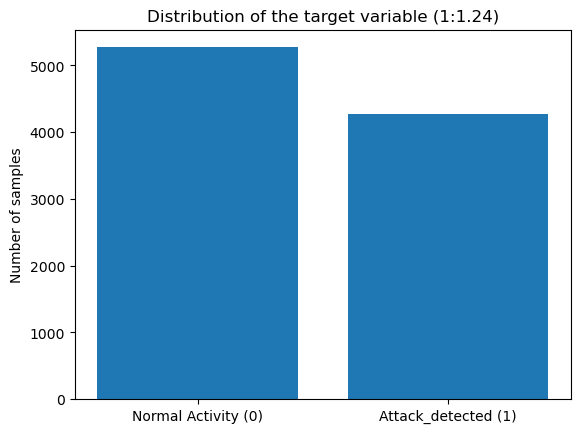

In [36]:
class_counts = df['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)

minority = class_counts.min()
majority = class_counts.max()
ratio = majority / minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['Normal Activity (0)', 'Attack_detected (1)'], class_counts)
plt.title(f"Distribution of the target variable (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.show()

The dataset shows an almost balanced class distribution (1:1.24). Since the imbalance is low, the risk of model bias is low

### Numerical features

**Correlation matrix**

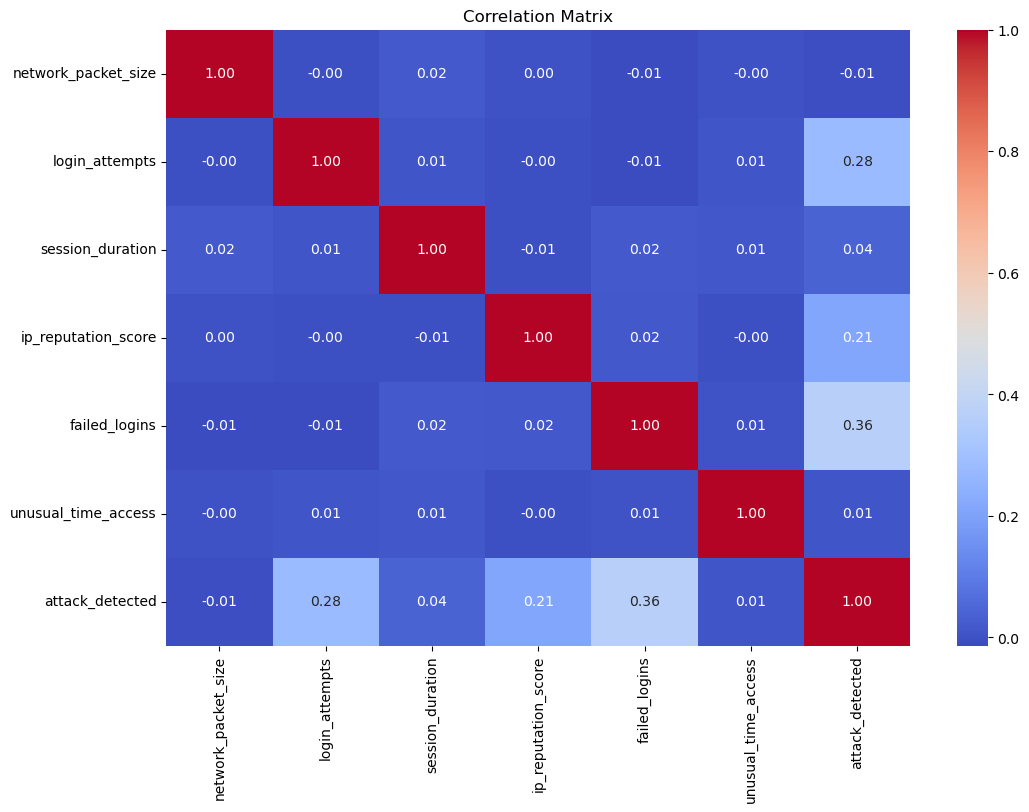

In [37]:
# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include=np.number)

# Matrice de corrélation
plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix highlights that the variables failed_logins (0.36), login_attempts (0.28) and ip_reputation_score (0.21) are those with the strongest links to the target variable attack_detected. This suggests that a significant number of failed logins or login attempts increases the probability of an attack being detected. Inversely, variables such as network_packet_size, session_duration, and unusual_time_access show correlations close to zero, indicating no significant linear relationship with attack detection.

**Correlation matrix of the numerical features and the target**

attack_detected        1.000000
failed_logins          0.363726
login_attempts         0.277320
ip_reputation_score    0.211540
session_duration       0.041602
unusual_time_access    0.008652
network_packet_size   -0.006798
Name: attack_detected, dtype: float64


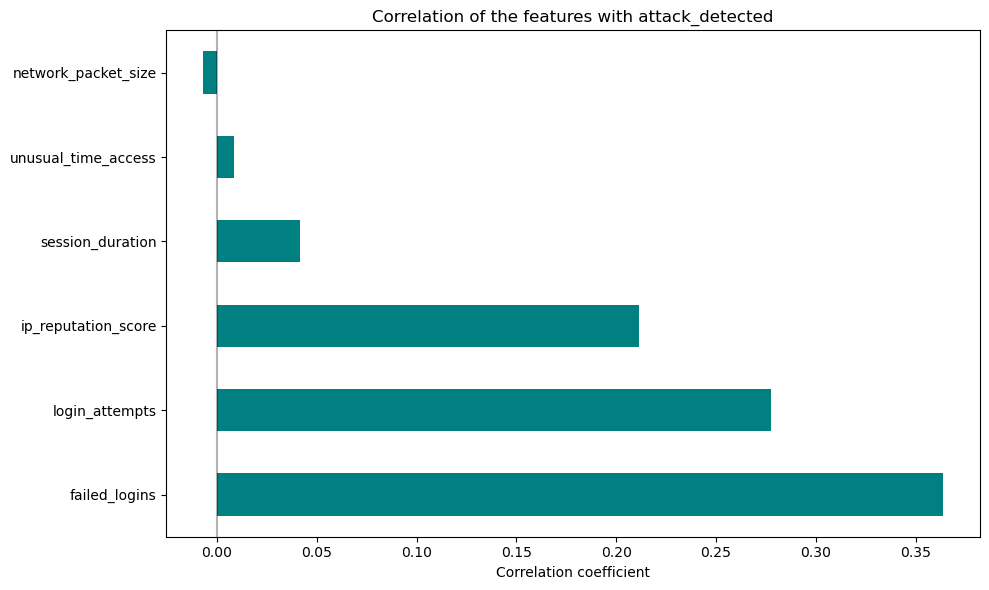

In [38]:
# Correlation with the target
numerical_features = [col for col in numeric_cols if col != 'attack_detected']
correlation_matrix = df[numerical_features + ['attack_detected']].corr()
target_correlation = correlation_matrix['attack_detected'].sort_values(ascending=False)
print(target_correlation)

# Visualization of the correlation with the target
plt.figure(figsize=(10, 6))
target_correlation.drop('attack_detected').plot(kind='barh', color='teal')
plt.title('Correlation of the features with attack_detected')
plt.xlabel('Correlation coefficient')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

**Box plots of the numerical features**

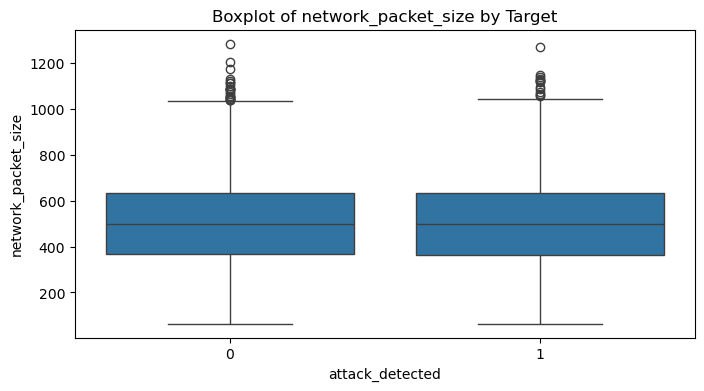

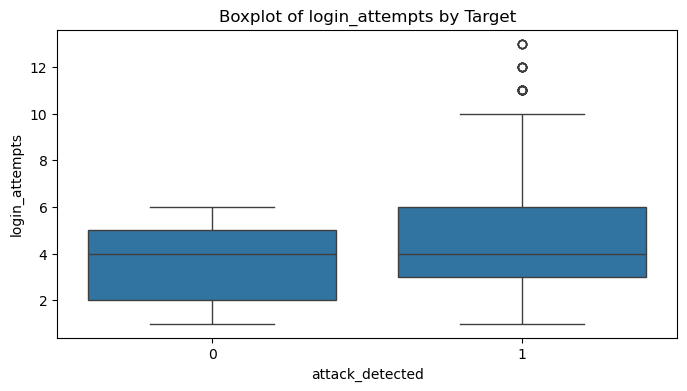

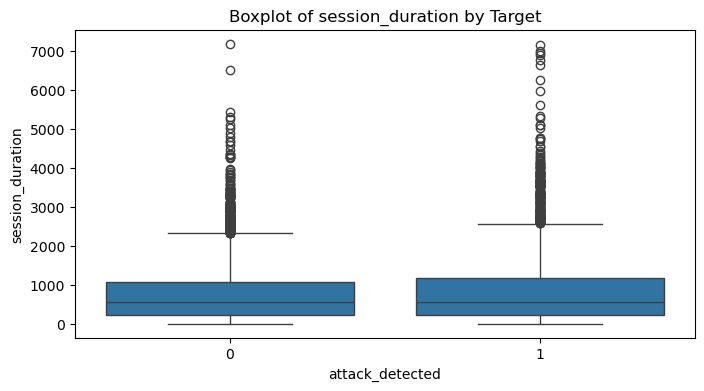

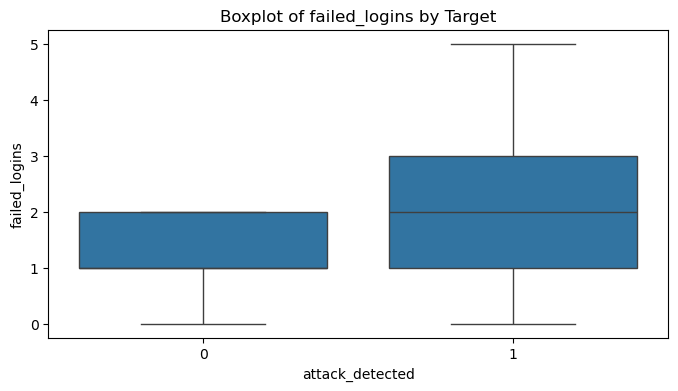

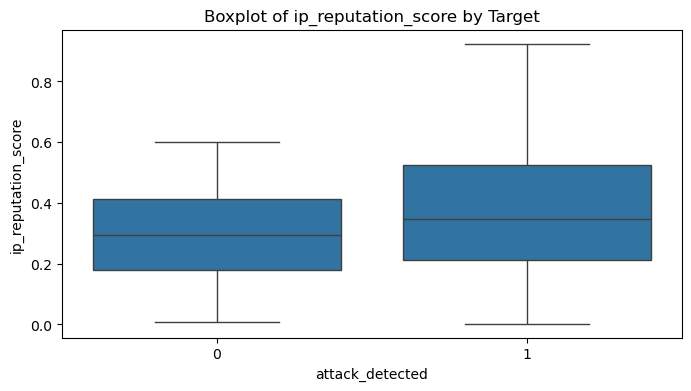

In [39]:
numerical_features = ['network_packet_size', 'login_attempts', 'session_duration', 'failed_logins', 'ip_reputation_score']

for feature in numerical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='attack_detected', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Target')
    plt.show()

## Object features

**Protocol type**

Protocol type distribution
protocol_type
TCP     6624
UDP     2406
ICMP     507
Name: count, dtype: int64


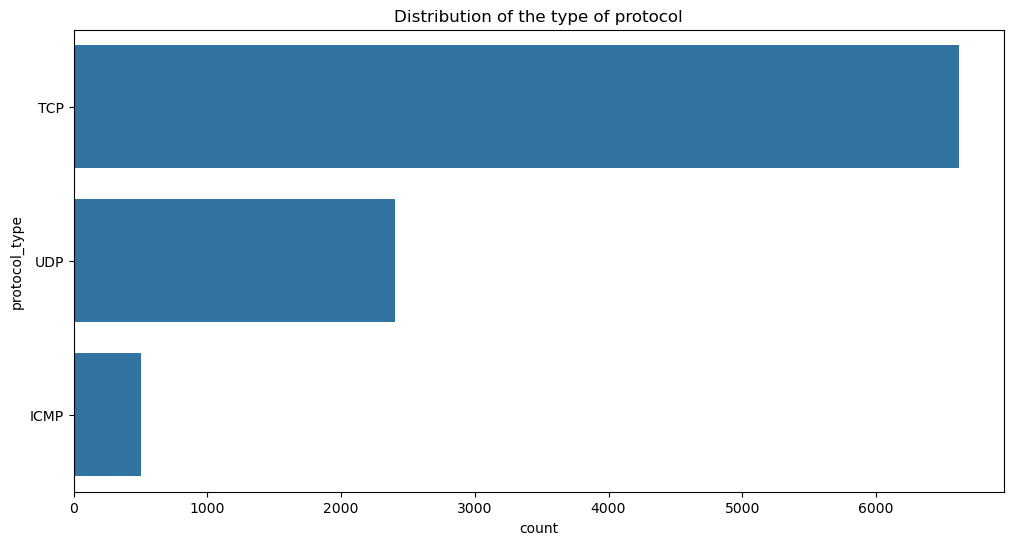

Text(0.5, 1.0, 'Protocol type pie chart')

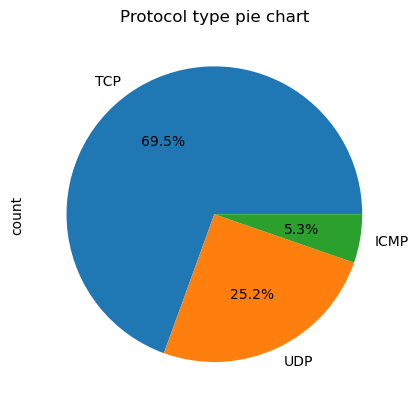

In [40]:
print("Protocol type distribution")
print(df['protocol_type'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='protocol_type', data=df, order=df['protocol_type'].value_counts().index)
plt.title('Distribution of the type of protocol')
plt.show()

df['protocol_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Protocol type pie chart')

**Encryption used**

Encryption used distribution
encryption_used
AES    4706
DES    2865
Name: count, dtype: int64


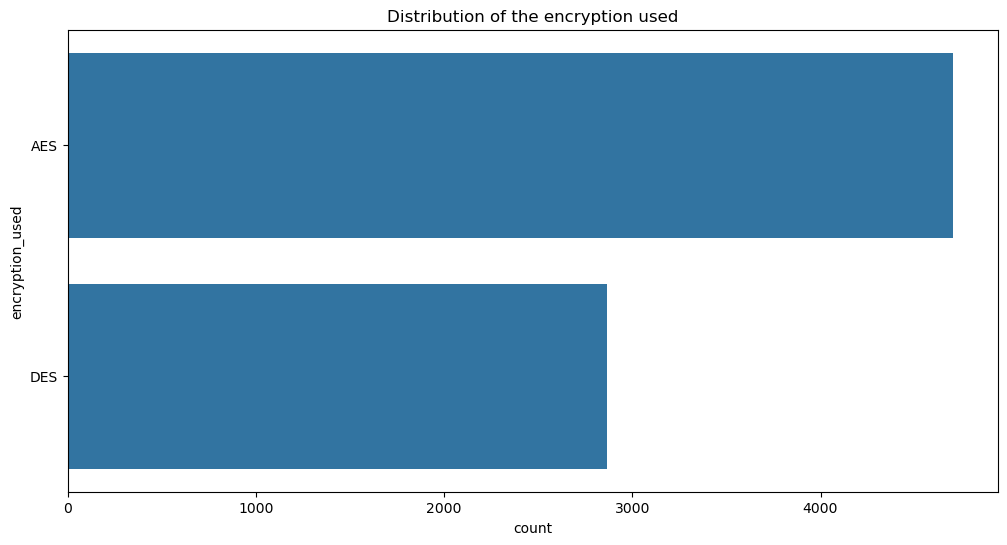

Text(0.5, 1.0, 'Encryption used pie chart')

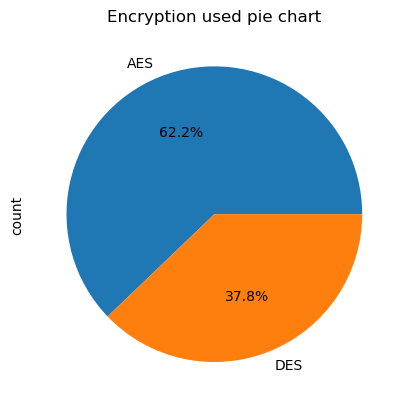

In [41]:
print("Encryption used distribution")
print(df['encryption_used'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='encryption_used', data=df, order=df['encryption_used'].value_counts().index)
plt.title('Distribution of the encryption used')
plt.show()

df['encryption_used'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Encryption used pie chart')

**Browser type**

Browser type distribution
browser_type
Chrome     5137
Firefox    1944
Edge       1469
Unknown     502
Safari      485
Name: count, dtype: int64


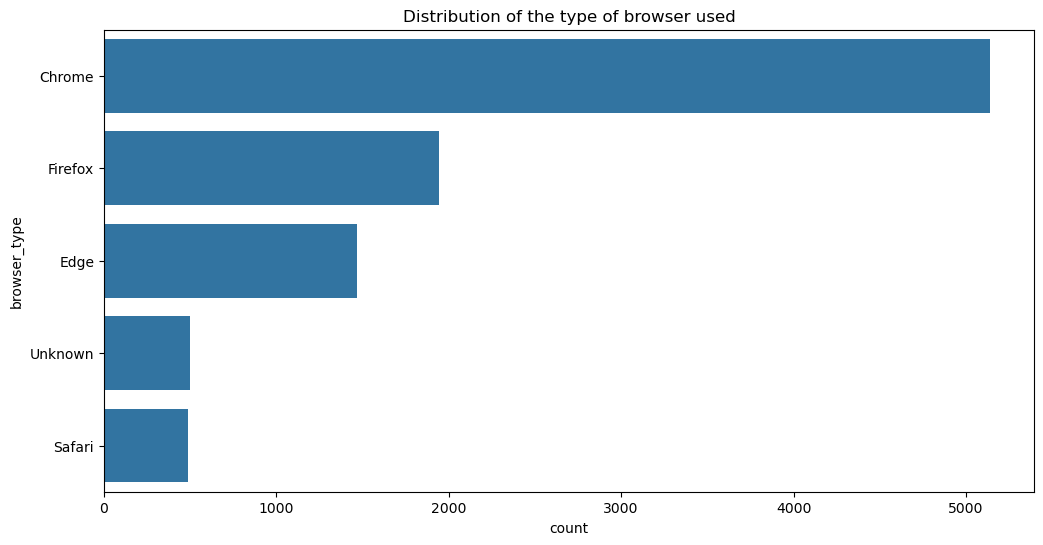

Text(0.5, 1.0, 'Browser type pie chart')

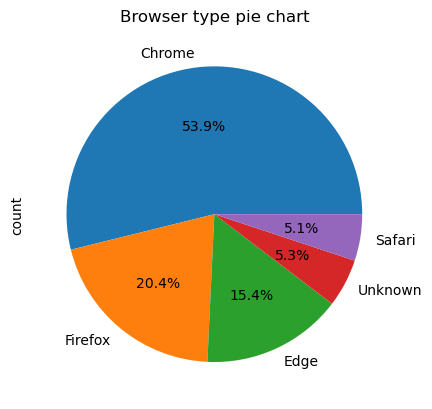

In [42]:
print("Browser type distribution")
print(df['browser_type'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='browser_type', data=df, order=df['browser_type'].value_counts().index)
plt.title('Distribution of the type of browser used')
plt.show()

df['browser_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Browser type pie chart')

**Cross analysis with attack_detected**

In [43]:
# Protocol_type vs Attack
protocol_attack = pd.crosstab(df['protocol_type'], df['attack_detected'], normalize='index') * 100
print("Protocol_type vs Attack (%):")
print(protocol_attack.round(2))

# Encryption_used vs Attack
encryption_attack = pd.crosstab(df['encryption_used'], df['attack_detected'], normalize='index') * 100
print("\nEncryption_used vs Attack (%):")
print(encryption_attack.round(2))

# Browser_type vs Attack
browser_attack = pd.crosstab(df['browser_type'], df['attack_detected'], normalize='index') * 100
print("\nBrowser_type vs Attack (%):")
print(browser_attack.round(2))

Protocol_type vs Attack (%):
attack_detected      0      1
protocol_type                
ICMP             58.78  41.22
TCP              55.27  44.73
UDP              54.61  45.39

Encryption_used vs Attack (%):
attack_detected      0      1
encryption_used              
AES              56.33  43.67
DES              54.66  45.34

Browser_type vs Attack (%):
attack_detected      0      1
browser_type                 
Chrome           57.13  42.87
Edge             56.23  43.77
Firefox          56.33  43.67
Safari           58.14  41.86
Unknown          26.89  73.11


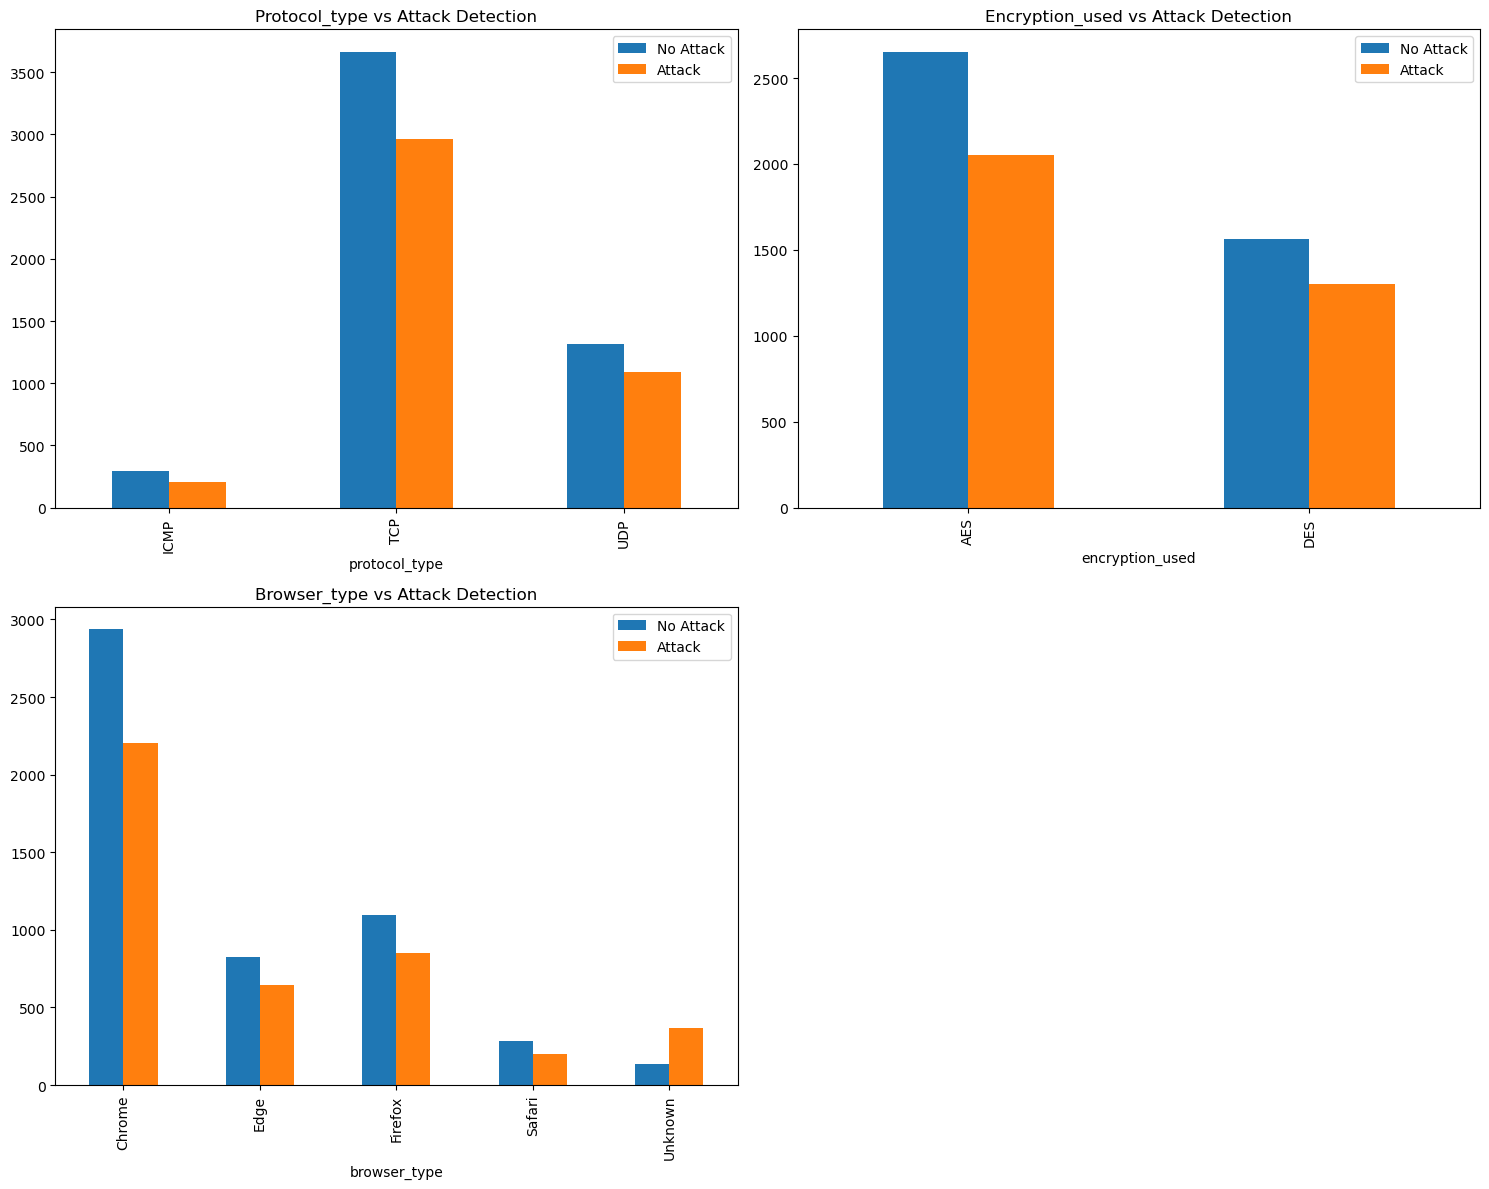

In [44]:
# Visualization of the cross-analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Protocol_type
pd.crosstab(df['protocol_type'], df['attack_detected']).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Protocol_type vs Attack Detection')
axes[0,0].legend(['No Attack', 'Attack'])

# Encryption_used
pd.crosstab(df['encryption_used'], df['attack_detected']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Encryption_used vs Attack Detection')
axes[0,1].legend(['No Attack', 'Attack'])

# Browser_type
pd.crosstab(df['browser_type'], df['attack_detected']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Browser_type vs Attack Detection')
axes[1,0].legend(['No Attack', 'Attack'])

# Attack rate by category
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

### Pre-processing

**Handling missing values**

In [4]:
df['encryption_used'].fillna('Unknown', inplace=True)

**Encode categorial features**

In [5]:
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

**Train/test split**

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['attack_detected', 'session_id'], axis=1)

y = df['attack_detected']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (7629, 14), Test size: (1908, 14)


**Resampling analysis**

In [48]:
samplers = {
    "No Rebalancing": None,
    "Random OverSampling": RandomOverSampler(random_state=42),
    "Random UnderSampling": RandomUnderSampler(random_state=42)
}

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
conf_matrices = {}

for name, sampler in samplers.items():
    print(f"\n=== {name} ===")

    X_res, y_res = (X_train, y_train)
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    print("Class distribution after sampling:", Counter(y_res))

    model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')

    f1_scores, auc_scores = [], []
    conf_sum = np.zeros((2,2))

    for train_idx, val_idx in cv.split(X_res, y_res):
        X_tr, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
        y_tr, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]


        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        f1_scores.append(f1_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_proba))
        conf_sum += confusion_matrix(y_val, y_pred)

    conf_avg = conf_sum / cv.get_n_splits()
    conf_matrices[name] = conf_avg

    results.append({
        'Method': name,
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores),
        'AUC_mean': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores)
    })



=== No Rebalancing ===
Class distribution after sampling: Counter({0: 4218, 1: 3411})

=== Random OverSampling ===
Class distribution after sampling: Counter({0: 4218, 1: 4218})

=== Random UnderSampling ===
Class distribution after sampling: Counter({0: 3411, 1: 3411})


In [50]:
results_df = pd.DataFrame(results)
print("\n=== Cross-Validation Results ===")
print(results_df.round(3))


=== Cross-Validation Results ===
                 Method  F1_mean  F1_std  AUC_mean  AUC_std
0        No Rebalancing    0.866   0.011     0.887    0.008
1   Random OverSampling    0.865   0.002     0.888    0.003
2  Random UnderSampling    0.866   0.005     0.887    0.005


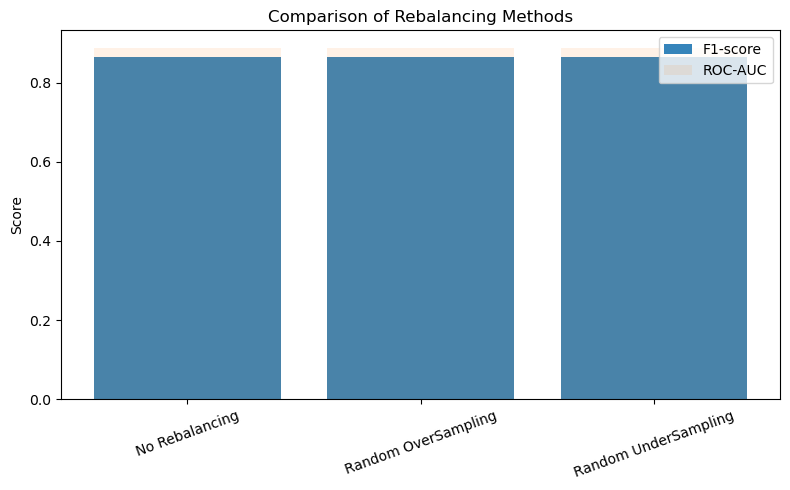

In [51]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Method'], results_df['F1_mean'], alpha=0.9, label='F1-score')
plt.bar(results_df['Method'], results_df['AUC_mean'], alpha=0.1, label='ROC-AUC')
plt.title("Comparison of Rebalancing Methods")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

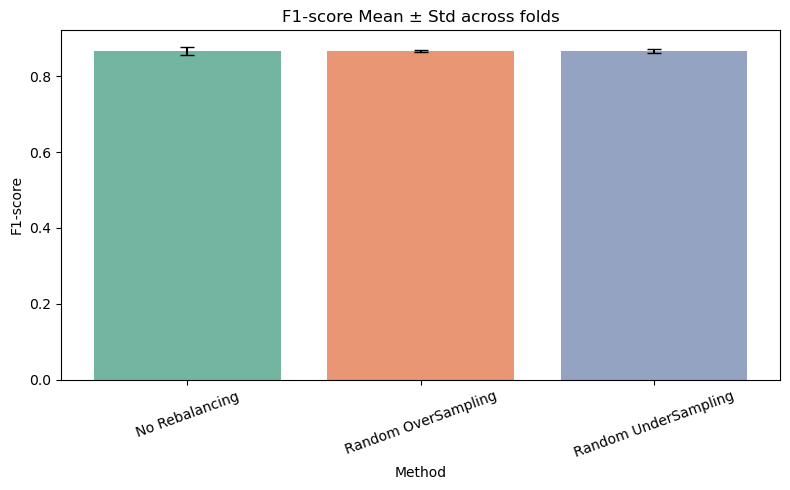

In [52]:
plt.figure(figsize=(8,5))
sns.barplot(x="Method", y="F1_mean", hue="Method", data=results_df, palette="Set2", errorbar=None, legend=False)
plt.errorbar(x=np.arange(len(results_df)), y=results_df["F1_mean"],
             yerr=results_df["F1_std"], fmt='none', ecolor='black', capsize=5)
plt.title("F1-score Mean ± Std across folds")
plt.ylabel("F1-score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In this analysis, we tested several resampling techniques. However, the data is nearly balanced (imbalance ratio = 1:1.24), and resampling did not improve model performance. Therefore, we decided not to apply resampling in the upcoming models.

## 3. Formalization of the problem

The goal of this project is to develop a supervised model capable of detecting cybersecurity intrusion based on network traffic and user behavior

This task is a binary classification problem : the model must predict whether a given network session corresponds to a normal activity (0) or an attack (1).

The input features are : network_packet_size, protocol_type, encryption_used, login_attemps, session_duration, failed_logins, browser_type, unusual_time_access, ip_reputation_score

The output variable is attack_detected which is a binary variable that indicates if the session corresponds to an intrusion (1) or a normal activity (0).

As a baseline model, we will implement a Decision Tree Classifier. We chose this algorithm because it is easy to interpret and quick to train and it can handle both categorical and numerical data.

The baseline model will help us to have a reference performance, which will then enable us to measure the improvements achieved through the application of more advanced models or techniques

## 4. Implementation of the first model

In [10]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):

    # Train
    model.fit(X_train, y_train)

    # Predict classes
    y_pred = model.predict(X_test)

    # Predict probabilities (for ROC-AUC)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Display results
    print(f"=== {model.__class__.__name__} ===")
    print(f"F1-score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")
    print(f"Accuracy: {acc:.3f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix 
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal (0)', 'Attack (1)'],
                yticklabels=['Normal (0)', 'Attack (1)'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


=== DecisionTreeClassifier ===
F1-score: 0.791
AUC: 0.811
Accuracy: 0.812

Classification report:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1055
           1       0.79      0.79      0.79       853

    accuracy                           0.81      1908
   macro avg       0.81      0.81      0.81      1908
weighted avg       0.81      0.81      0.81      1908



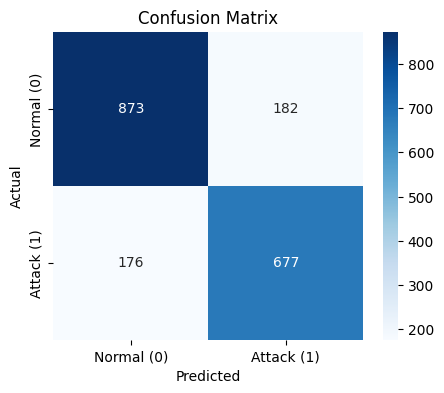

In [ ]:
model_decision_tree = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(model_decision_tree, X_train, y_train, X_test, y_test)

=== DecisionTreeClassifier ===
F1-score: 0.851
AUC: 0.872
Accuracy: 0.884

Classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.74      0.85       853

    accuracy                           0.88      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.88      0.88      1908



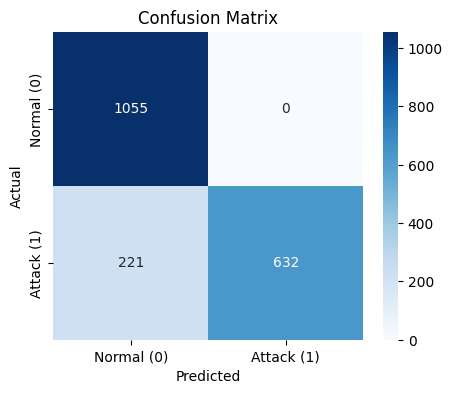

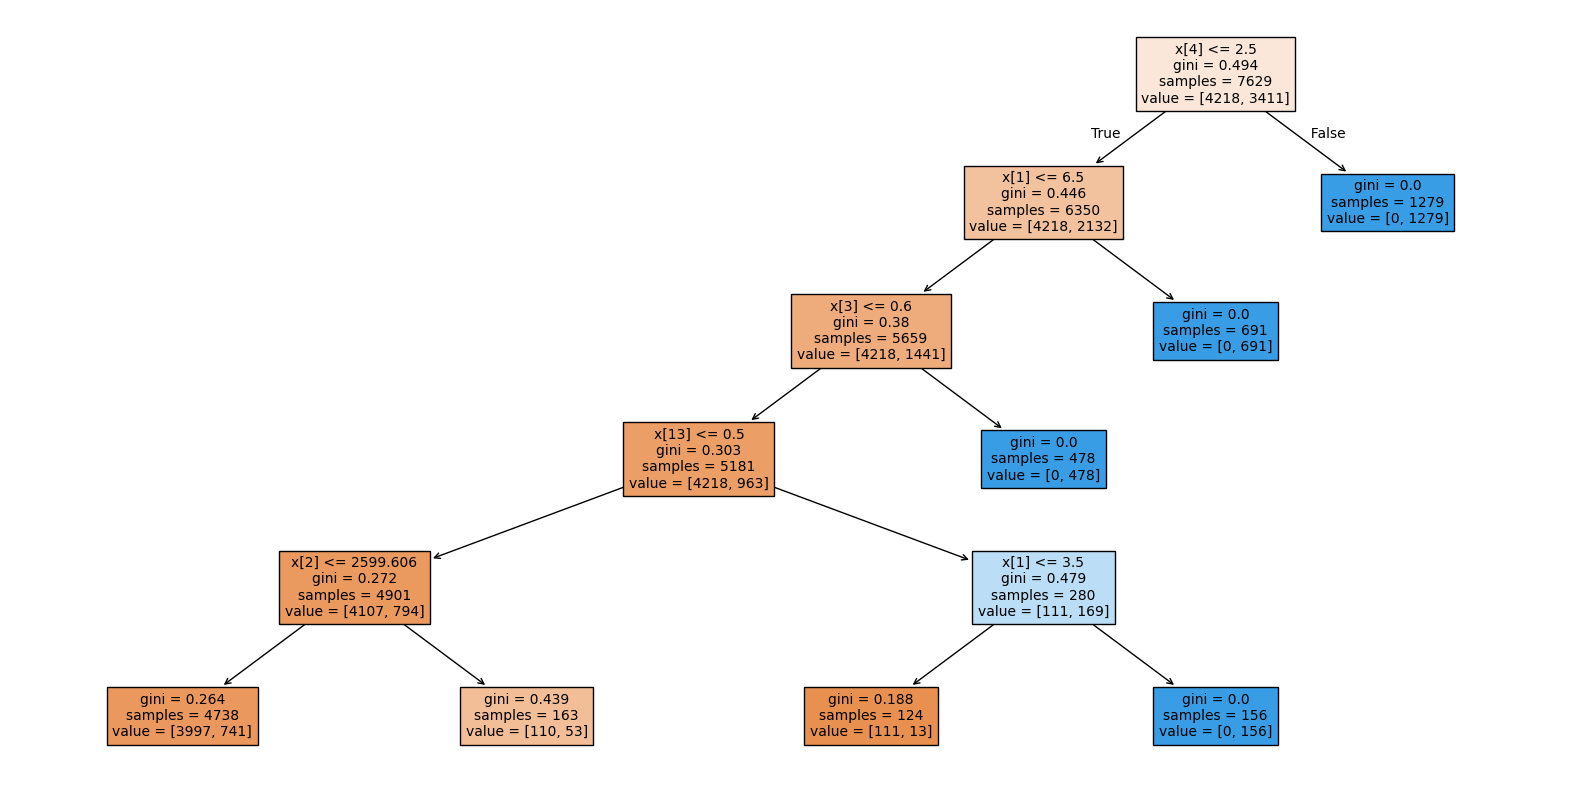

In [12]:
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(random_state=42, max_depth=5)
train_and_evaluate_model(tree, X_train, y_train, X_test, y_test)

plt.figure(figsize=(20, 10))

plot_tree(
    tree,
    filled=True,
    fontsize=10
)

plt.show()

## RandomForest 

=== RandomForestClassifier ===
F1-score: 0.854
AUC: 0.879
Accuracy: 0.886

Classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908



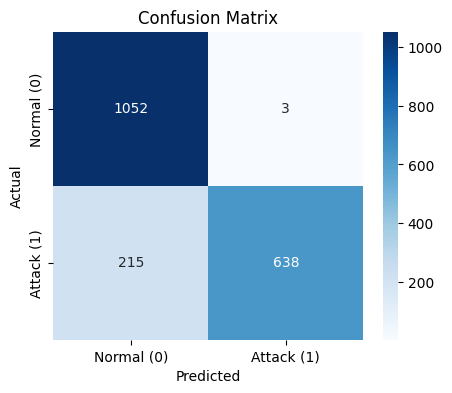

In [ ]:
model_random_forest = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

train_and_evaluate_model(model_random_forest, X_train, y_train, X_test, y_test)

**Hyperparameter optimization**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,                
    scoring='f1',             
    cv=3,                     
    verbose=2,
    n_jobs=-1,                
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)
print("Best F1-score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'class_weight': None, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 491}
Best F1-score: 0.8700307219737313


=== RandomForestClassifier ===
F1-score: 0.854
AUC: 0.879
Accuracy: 0.886

Classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908



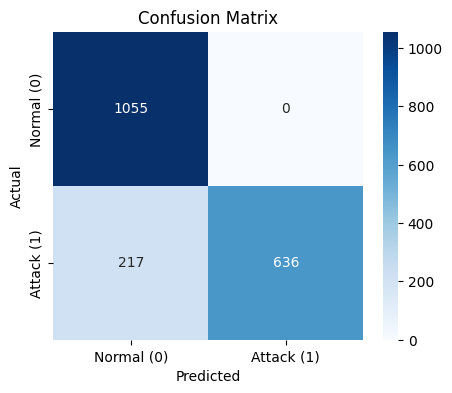

In [ ]:
best_rf = random_search.best_estimator_
train_and_evaluate_model(best_rf, X_train, y_train, X_test, y_test)

The confusion matrix highlights a major problem with false negatives : 217 attacks are incorrectly classified as normal. This represents a significant risk since a significant proportion of malicious activity goes undetected.

We checked whether the imbalance in the dataset could be the cause of these results. After applying SMOTE resampling technique, the performance remained broadly similar. This indicates that the problem does not stem primarily from class imbalance, but rather from the model's limitations in correctly distinguishing certain attacks.

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Avant SMOTE:", y_train.value_counts())
print("Après SMOTE:", y_train_resampled.value_counts())


Avant SMOTE: attack_detected
0    4218
1    3411
Name: count, dtype: int64
Après SMOTE: attack_detected
0    4218
1    4218
Name: count, dtype: int64


In [ ]:
model_rf_smote = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model_rf_smote.fit(X_train_resampled, y_train_resampled)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


=== RandomForestClassifier ===
F1-score: 0.854
AUC: 0.881
Accuracy: 0.885

Classification report:

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      1055
           1       0.99      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908



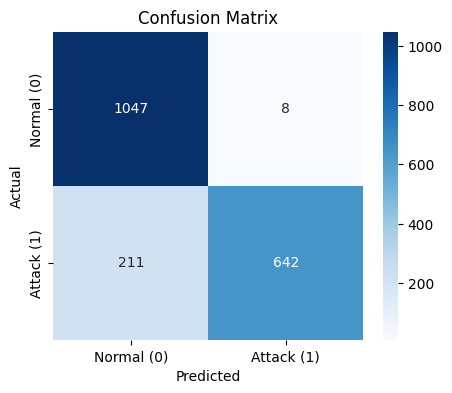

In [ ]:
train_and_evaluate_model(model_rf_smote, X_train_resampled, y_train_resampled, X_test, y_test)


Next, we attempted to adjust the decision threshold to make the model more sensitive to attacks. However, despite these modifications, no adjustment produced better results: false negatives remained too high and some attacks continued to be classified as normal sessions.

In [ ]:

y_proba = best_rf.predict_proba(X_test)[:, 1]


In [ ]:
thresholds = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25]

for t in thresholds:
    print(f"\n===== Seuil {t} =====")
    y_pred_t = (y_proba >= t).astype(int)
    
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred_t))
    
    print("\nClassification report :")
    print(classification_report(y_test, y_pred_t))


===== Seuil 0.5 =====
Matrice de confusion :
[[1055    0]
 [ 217  636]]

Classification report :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908


===== Seuil 0.45 =====
Matrice de confusion :
[[1055    0]
 [ 217  636]]

Classification report :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908


===== Seuil 0.4 =====
Matrice de confusion :
[[1054    1]
 [ 217  636]]

Classification report :
              precision    recall  f1-score   suppo

In [ ]:
from sklearn.metrics import f1_score

best_t = 0
best_f1 = 0

for t in np.arange(0.20, 0.61, 0.01):
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Meilleur seuil = {best_t:.2f} | F1 = {best_f1:.3f}")

Meilleur seuil = 0.44 | F1 = 0.854


In [ ]:
y_pred_final = (y_proba >= best_t).astype(int)

print("=== Performance finale avec seuil optimisé ===")
print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

=== Performance finale avec seuil optimisé ===
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908

[[1055    0]
 [ 217  636]]


## Gradient Boosting Classifier

=== GradientBoostingClassifier ===
F1-score: 0.854
AUC: 0.875
Accuracy: 0.886

Classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908



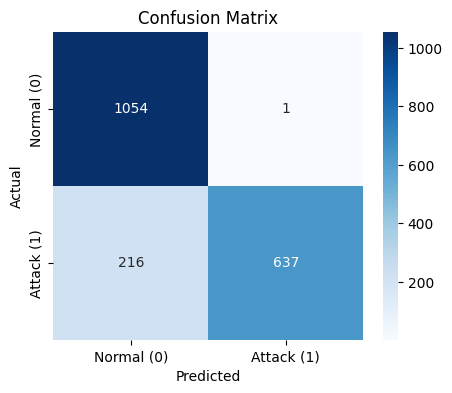

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(
    n_estimators=200,      
    learning_rate=0.1,     
    max_depth=3,           
    random_state=42
)

train_and_evaluate_model(model_gb, X_train, y_train, X_test, y_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]  
}

In [ ]:
scorer = make_scorer(f1_score, pos_label=1)

In [ ]:
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,            
    n_jobs=-1,        
    verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 4, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [ ]:
best_gb = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)


Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}


=== GradientBoostingClassifier ===
F1-score: 0.855
AUC: 0.877
Accuracy: 0.887

Classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.86       853

    accuracy                           0.89      1908
   macro avg       0.92      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908



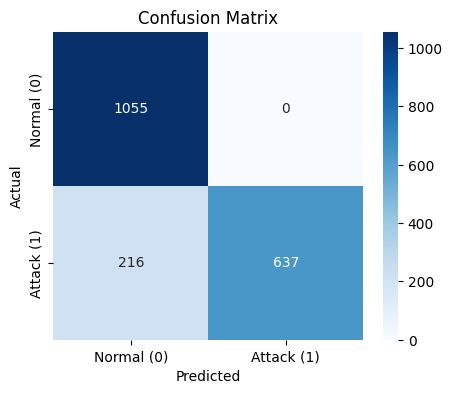

In [ ]:
train_and_evaluate_model(best_gb, X_train, y_train, X_test, y_test)


We also evaluated the Gradient Boosting Classifier but it has the same false negative problem as the other models: it struggles to correctly identify attacks. This leads us to believe that the limitation no longer stems from the algorithms themselves but rather from the dataset, whose quality or structure now seems to restrict possible performance.